# Clone my driving behavior

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Lambda, Dropout, Cropping2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

import cloning.image_generator as ig
from cloning.visualizations import plot_layers

Using TensorFlow backend.


In [2]:
user = !whoami
user = user[0]

In [3]:
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'
IMAGE_SHAPE = (160, 320, 3)

## Load images and measurements

In [4]:
def load_images_and_measurements(image_set_directory):
    driving_log = (
        pd.read_csv(
            f'./my-videos-center/{image_set_directory}/driving_log.csv', 
            header=None,
            names=[
                'center_image', 'left_image', 'right_image', 
                'steering_angle', 'throttle', 'break', 'speed'])
        .assign(
            center_image=lambda df: 
                PROJECT_DIR 
                + f'/my-videos-center/{image_set_directory}/IMG/' 
                + df['center_image'].str.split('IMG').str[1]))
    
    images = np.stack(driving_log['center_image'].map(plt.imread), axis=0)
    measurements = driving_log['steering_angle']
    
    return images, measurements

In [5]:
def load_image_sets(image_set_names):
    image_sets, measure_sets = zip(*[load_images_and_measurements(name) for name in image_set_names])
    
    return np.vstack(image_sets), np.hstack(measure_sets)

In [7]:
%%time
train_images, train_meas = load_image_sets([
    'first_drives', 
    '3_forward_rounds', 
    '3_backward_rounds',
    'edges_forward',
    'edges_backward',
    'edges_smooth',
    '2_rounds_for_testing',
    '3_more_fw_rounds',
    '3_more_bw_rounds',
#     'driving_on_the_edge_fw_left',
#     'driving_on_the_edge_fw_right',
#     '6_fw',
#     '6_bw',
#     '3_bw_hard',
#     '3_fw_hard',
#     '1_round_fw_hard_level'
])

print(f'Number of train samples: {train_meas.shape[0]}')

Number of train samples: 23400
CPU times: user 27.6 s, sys: 4.13 s, total: 31.8 s
Wall time: 34.7 s


In [8]:
%%time
valid_images, valid_meas = load_image_sets(["validation_rounds", "validation_rounds_bw"])
print(f'Number of valid samples: {valid_meas.shape[0]}')

Number of valid samples: 4234
CPU times: user 5.01 s, sys: 748 ms, total: 5.76 s
Wall time: 5.76 s


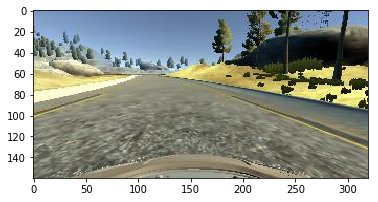

In [9]:
plt.imshow(next(ig.image_generator_from_dataset(train_images, train_meas, augment=True))[0][0])
plt.show()

In [10]:
model = Sequential([
    Cropping2D(cropping=((70, 25), (0, 0)), input_shape=IMAGE_SHAPE, name='crop'),
    Lambda(lambda image: image / 255.0 - 0.5, name='scale'),
    
    Conv2D(24, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(36, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(48, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(50),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer=Adam(lr=0.0005))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
crop (Cropping2D)            (None, 65, 320, 3)        0         
_________________________________________________________________
scale (Lambda)               (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 158, 24)       96        
_________________________________________________________________
activation_1 (Activation)    (None, 31, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 77, 36)        144       
__________

## Train model

In [12]:
batch_size = 32

train_generator = ig.image_generator_from_dataset(train_images, train_meas, augment=True, batch_size=batch_size)

In [13]:
%%time
steps_per_epoch = int(train_meas.shape[0] / batch_size)
validation_steps = int(valid_meas.shape[0] / batch_size)

model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


731/731 [==============================] - 78s 107ms/step - loss: 0.0200 - val_loss: 0.0065
CPU times: user 41.9 s, sys: 3.82 s, total: 45.7 s
Wall time: 1min 19s


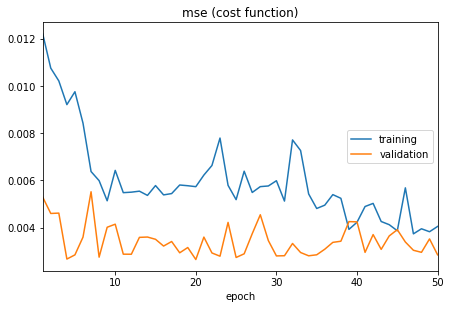

mse (cost function):
training   (min:    0.004, max:    0.012, cur:    0.004)
validation (min:    0.003, max:    0.006, cur:    0.003)
CPU times: user 31min 28s, sys: 1min 46s, total: 33min 14s
Wall time: 19min 29s


In [14]:
%%time
model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    callbacks=[PlotLossesKeras()],
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

In [15]:
validation_rmse = np.sqrt(model.evaluate(valid_images, valid_meas))

4234/4234 [==============================] - 2s 420us/step


In [16]:
model.save('./models/model_nvidia_remake_added_new_fw_bw_datasets_50_epochs.h5a')

In [17]:
!./upload_models_to_s3.sh

upload: models/model_nvidia_remake_added_new_fw_bw_datasets_50_epochs.h5a to s3://behavioral-cloning-models/model_nvidia_remake_added_new_fw_bw_datasets_50_epochs.h5a


## Compare original and predicted angle distributions

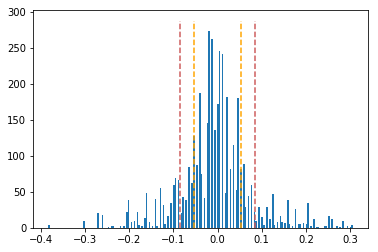

In [18]:
plt.hist(valid_meas, bins=200)
ylim = plt.ylim()
std = valid_meas.std()

plt.vlines(validation_rmse, *ylim, color='orange', linestyle='--')
plt.vlines(-validation_rmse, *ylim, color='orange', linestyle='--')
plt.vlines(std, *ylim, color='indianred', linestyle='--')
plt.vlines(-std, *ylim, color='indianred', linestyle='--')
plt.show()

In [20]:
%%time
predictions = model.predict(valid_images)

CPU times: user 1.88 s, sys: 0 ns, total: 1.88 s
Wall time: 1.75 s


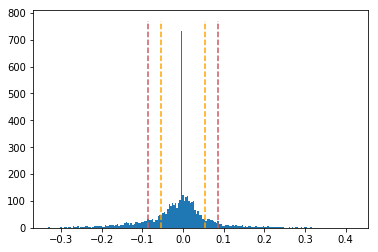

In [21]:
plt.hist(predictions, bins=200)
ylim = plt.ylim()
std = valid_meas.std()

plt.vlines(validation_rmse, *ylim, color='orange', linestyle='--')
plt.vlines(-validation_rmse, *ylim, color='orange', linestyle='--')
plt.vlines(std, *ylim, color='indianred', linestyle='--')
plt.vlines(-std, *ylim, color='indianred', linestyle='--')

plt.show()

## Visualize output of convolution layers

In [22]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

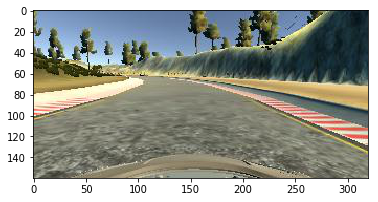

In [23]:
test_image = valid_images[0]
plt.imshow(test_image)
plt.show()

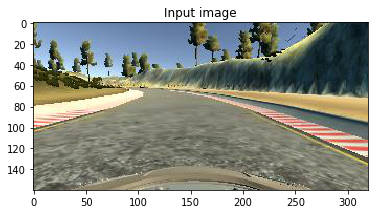

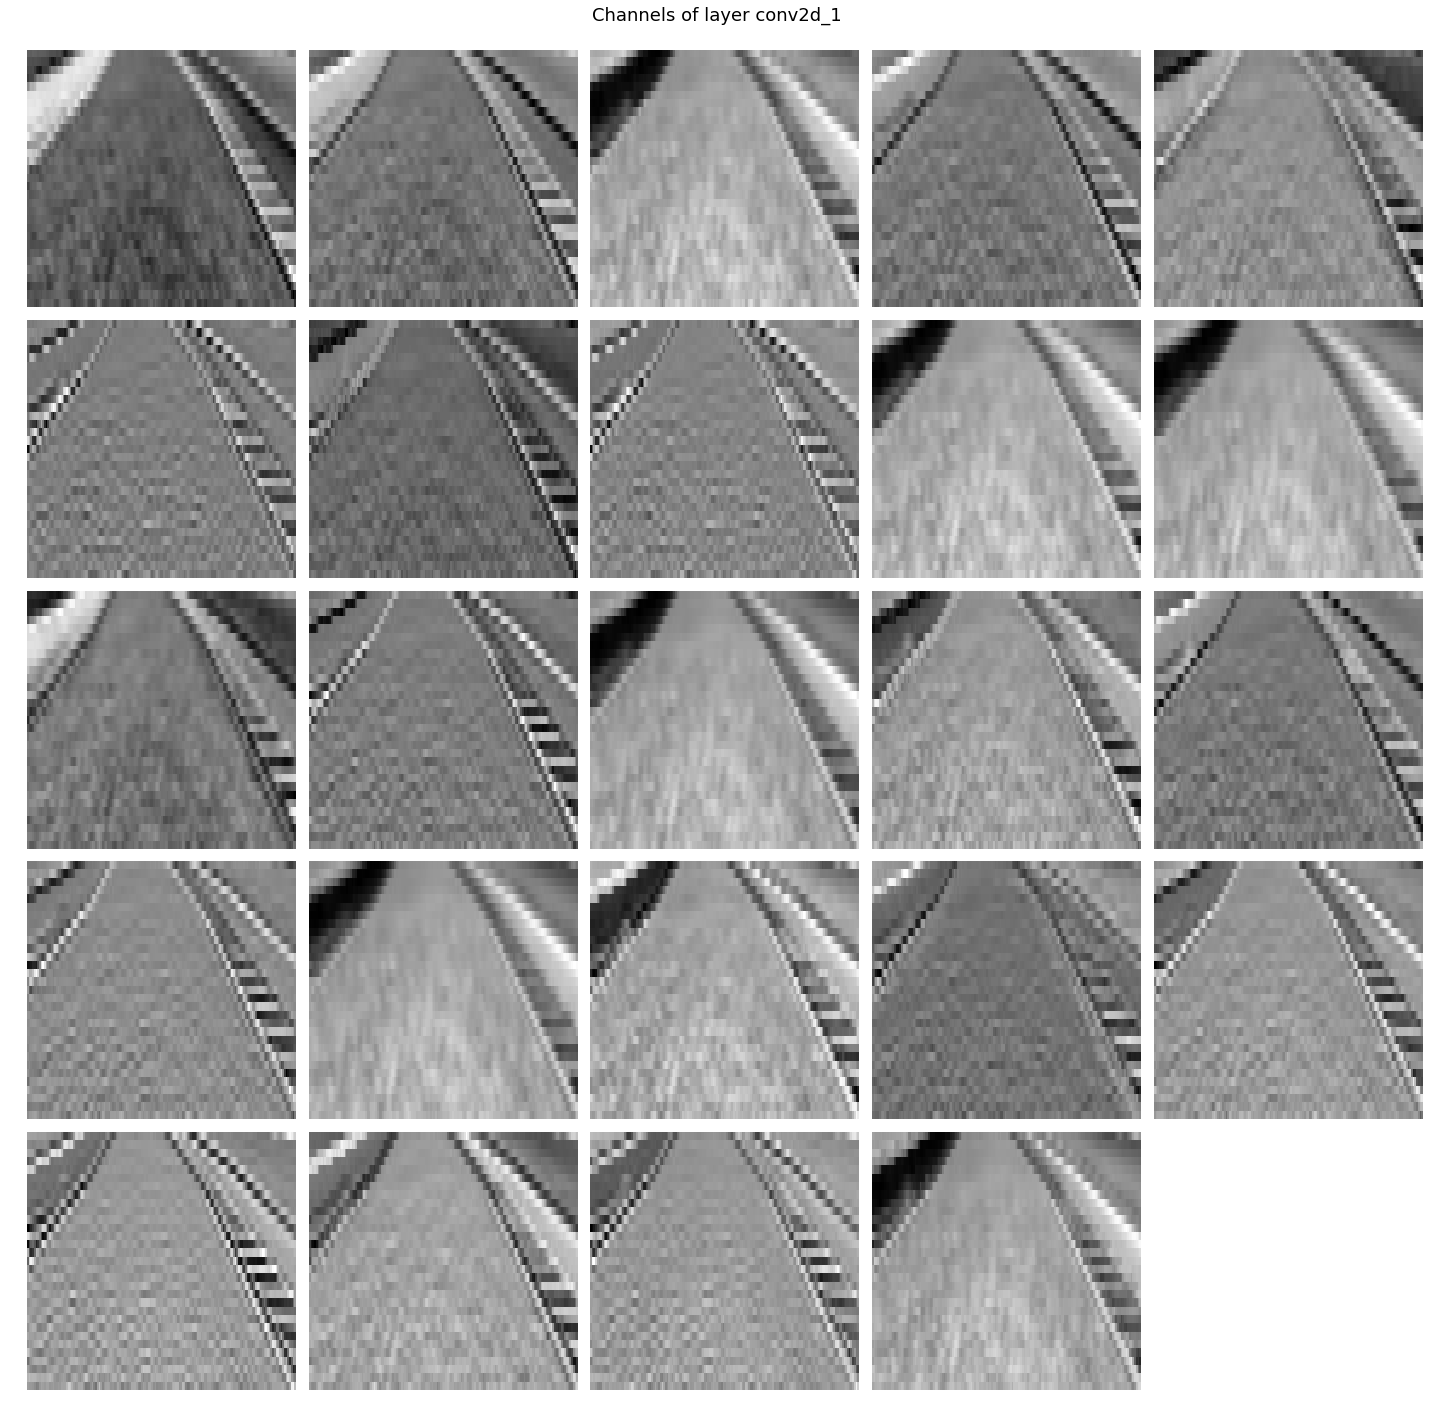

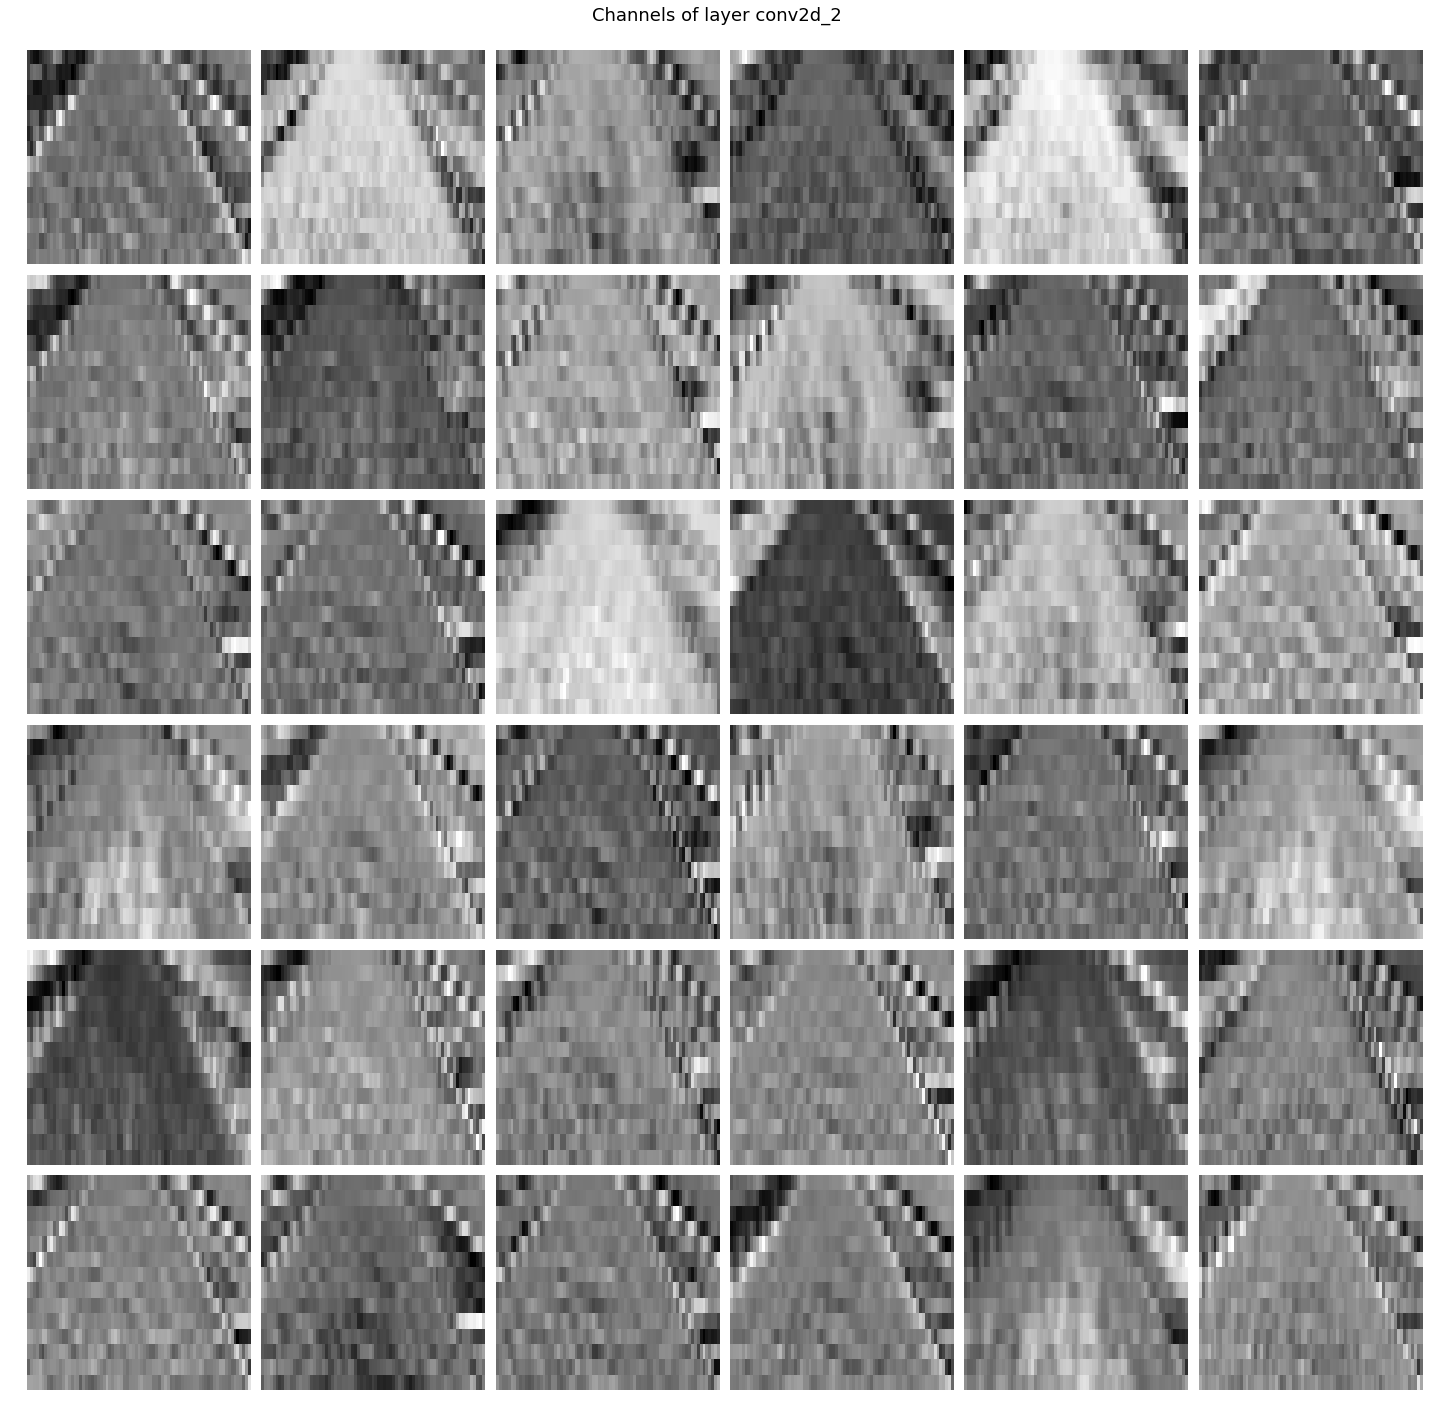

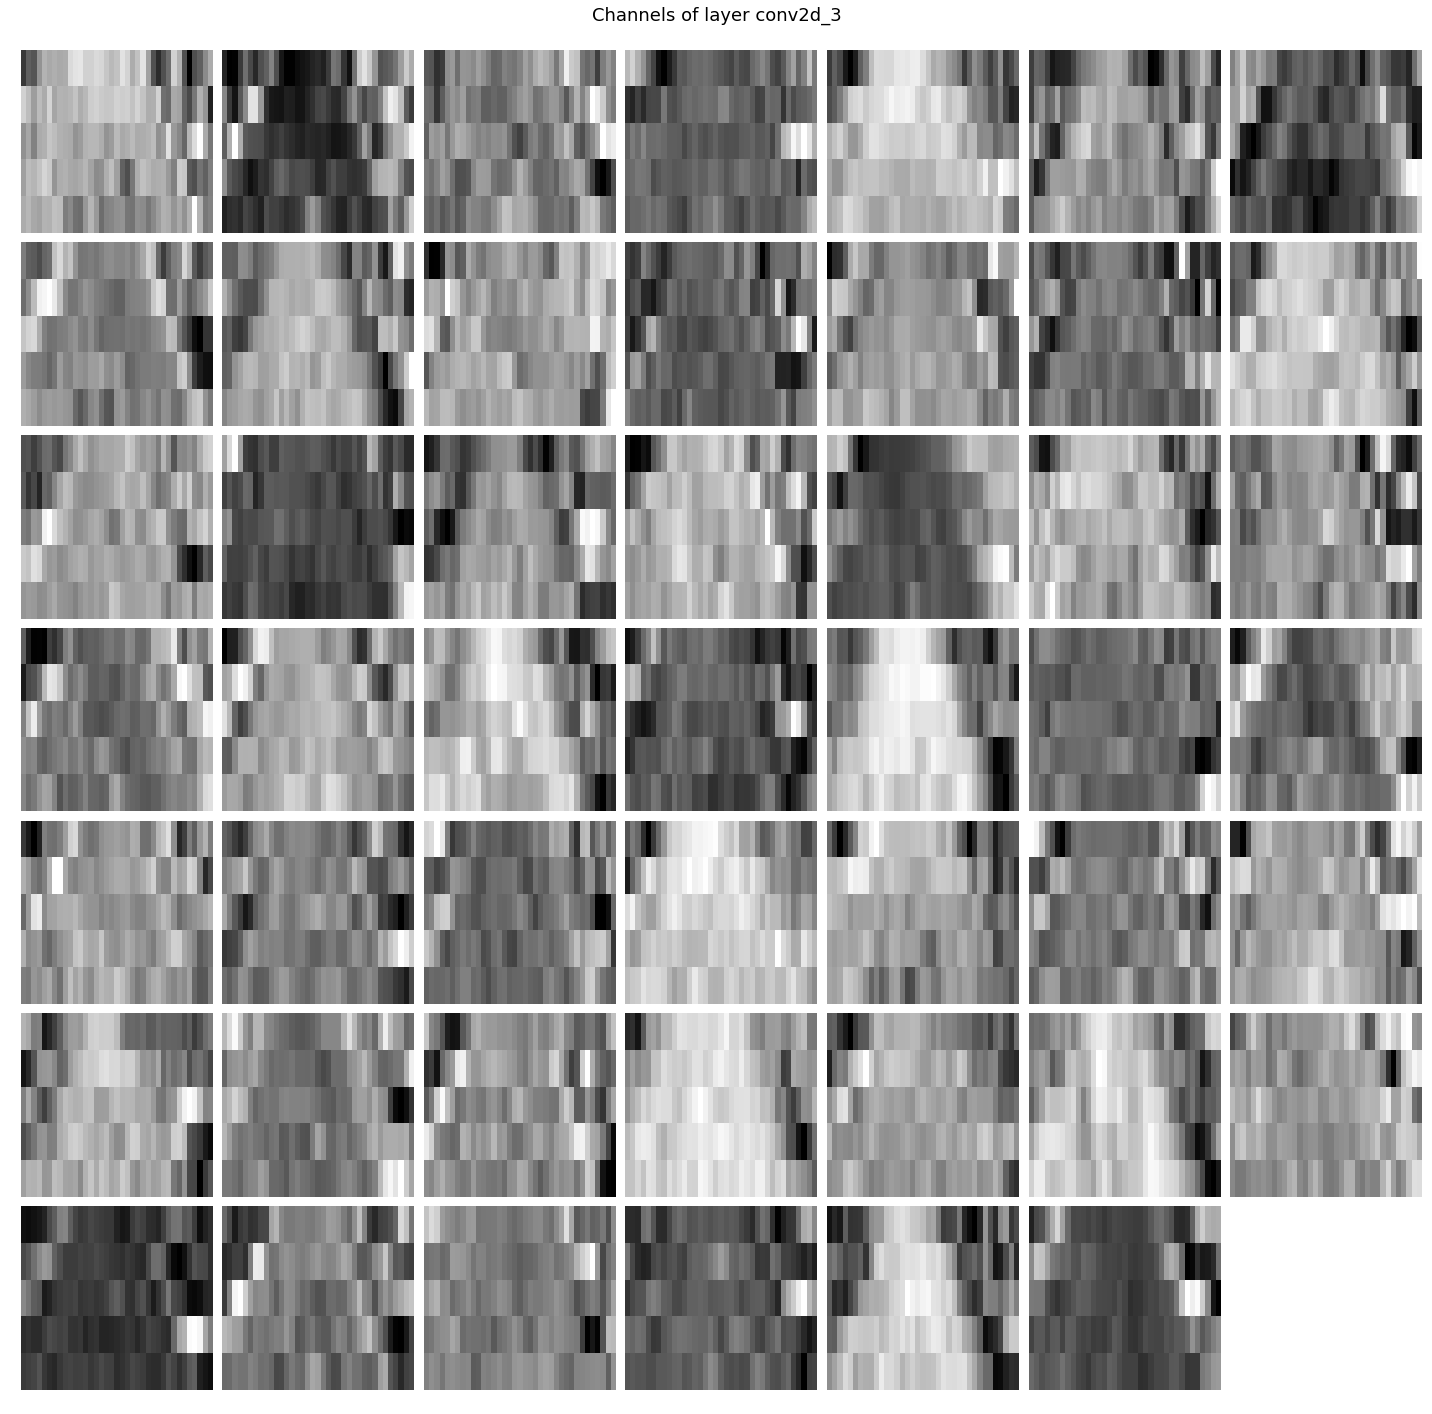

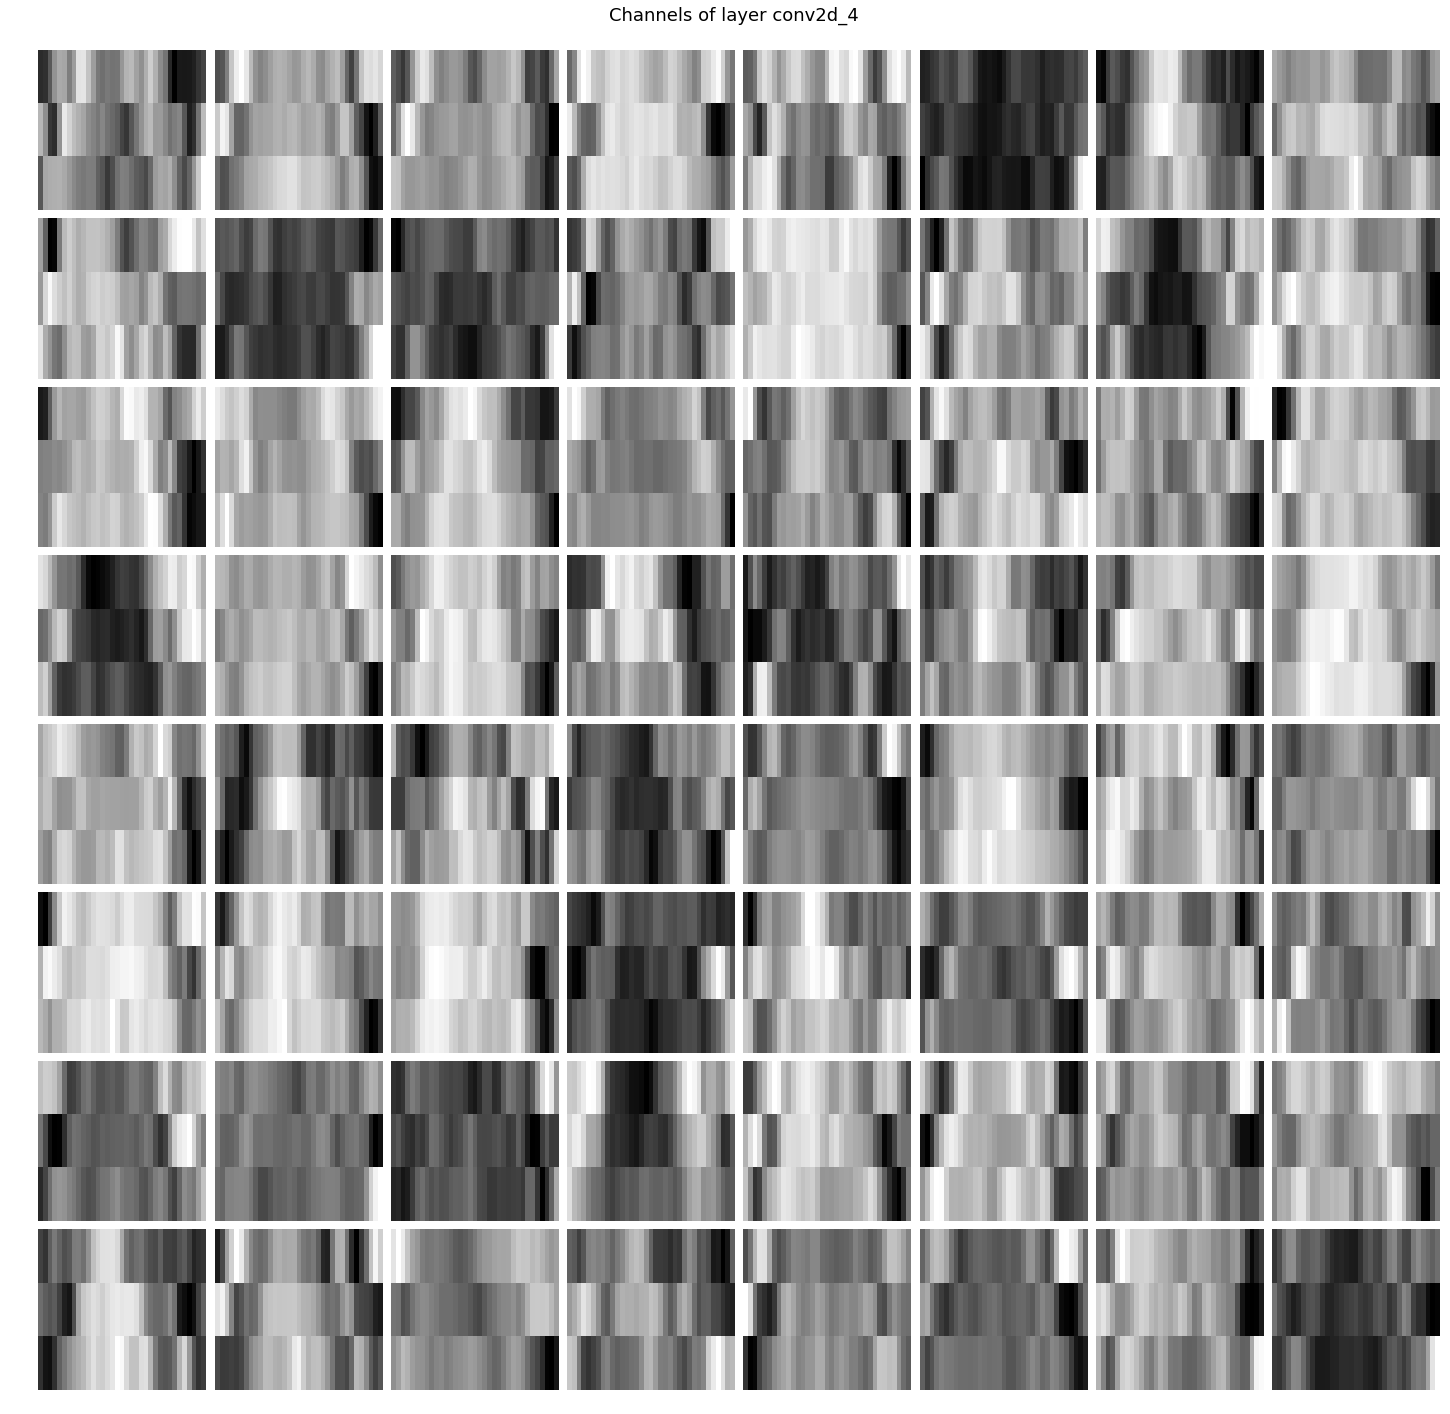

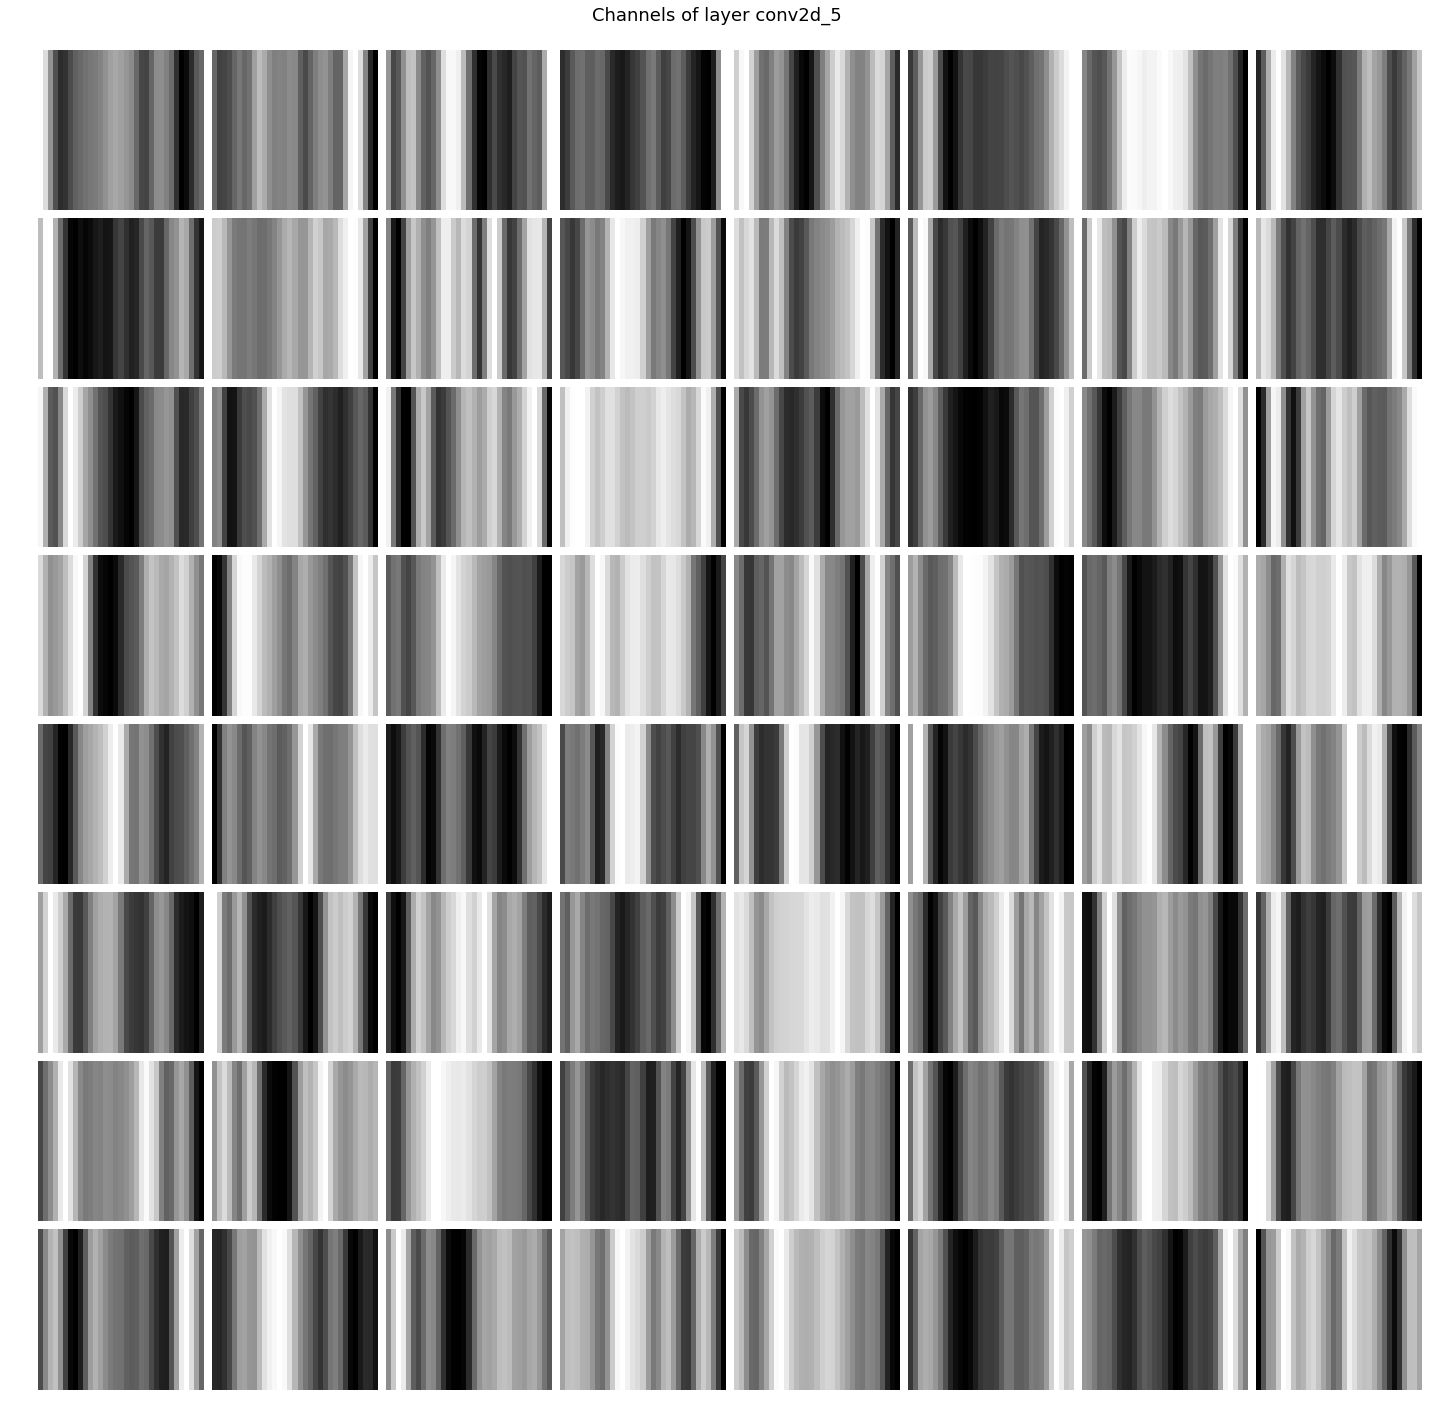

In [24]:
plot_layers(test_image, evaluation_functions, layer_names)